In [13]:
# Pip install method (recommended)

!pip install ultralytics


In [14]:
!pip install supervision

In [15]:
import supervision as sv

# List top-level attributes and submodules
print(dir(sv))


['BaseDataset', 'BlurAnnotator', 'BoundingBoxAnnotator', 'BoxAnnotator', 'BoxCornerAnnotator', 'ByteTrack', 'CSVSink', 'CircleAnnotator', 'ClassificationDataset', 'Classifications', 'Color', 'ColorAnnotator', 'ColorLookup', 'ColorPalette', 'ConfusionMatrix', 'CropAnnotator', 'DetectionDataset', 'Detections', 'DetectionsSmoother', 'DotAnnotator', 'EdgeAnnotator', 'EllipseAnnotator', 'FPSMonitor', 'HaloAnnotator', 'HeatMapAnnotator', 'ImageSink', 'InferenceSlicer', 'JSONSink', 'KeyPoints', 'LMM', 'LabelAnnotator', 'LineZone', 'LineZoneAnnotator', 'MaskAnnotator', 'MeanAveragePrecision', 'OrientedBoxAnnotator', 'OverlapFilter', 'PercentageBarAnnotator', 'PixelateAnnotator', 'Point', 'PolygonAnnotator', 'PolygonZone', 'PolygonZoneAnnotator', 'Position', 'Rect', 'RichLabelAnnotator', 'RoundBoxAnnotator', 'TraceAnnotator', 'TriangleAnnotator', 'VertexAnnotator', 'VertexLabelAnnotator', 'VideoInfo', 'VideoSink', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '_

In [16]:
from supervision.draw.color import ColorPalette
from supervision import Point
from supervision import VideoInfo
from supervision import get_video_frames_generator
from supervision import VideoSink
from supervision import plot_image
from supervision import Detections, BoxAnnotator
from supervision import LineZone

In [24]:
import supervision as sv

In [25]:
MODEL = "/kaggle/input/visdrone-yolov8x-weights/best.pt"

In [26]:
SOURCE_VIDEO_PATH = "/kaggle/input/visdrone-traffic-video/traffic_analysis.mp4"

In [27]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 268 layers, 68,133,198 parameters, 0 gradients, 257.4 GFLOPs


In [35]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [36]:
import cv2

# Path to the video file
video_path = '/kaggle/input/visdrone-traffic-video/traffic_analysis.mp4'

# Create a VideoCapture object
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error opening video file")

# Read a specific frame (e.g., 100th frame)
frame_number = 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

if ret:
    # Save the frame as an image file
    cv2.imwrite('frame_100.png', frame)
    print("Frame saved as frame_100.png")
else:
    print("Failed to retrieve the frame")

# Release the VideoCapture object
cap.release()


Frame saved as frame_100.png


In [28]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [1]


0: 384x640 1 pedestrian, 43 cars, 9 vans, 4 trucks, 1 motor, 27.5ms
Speed: 2.1ms preprocess, 27.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


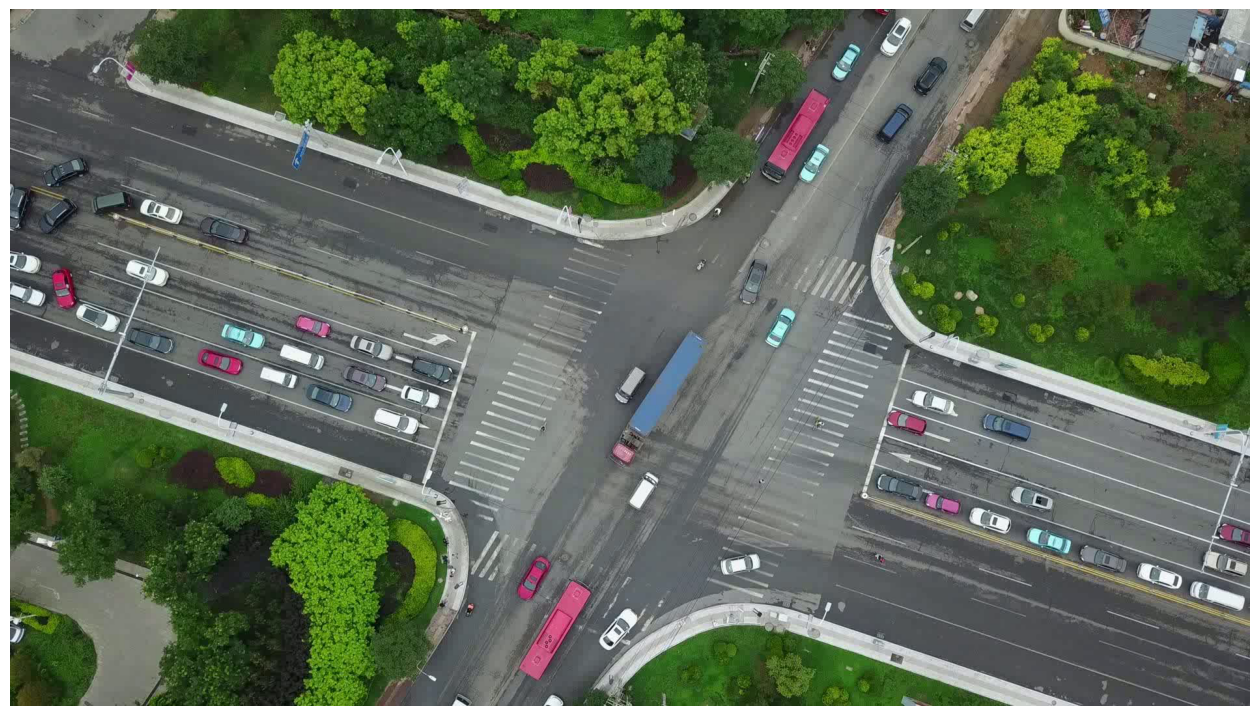

In [29]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
# format custom labels
# annotate and display frame
%matplotlib inline
plot_image(frame, (16, 16))

In [37]:
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv
from typing import List, Dict, Set, Iterable
import os
from tqdm import tqdm

COLORS = ColorPalette.from_hex(["#E6194B", "#3CB44B", "#FFE119", "#3C76D1"])

ZONE_IN_POLYGONS = [
    np.array([ [984, 360], [1122, 424], [1194, 316], [1058, 250]]),
    np.array([[756, 788], [864, 552], [680, 490], [550, 710]]),
    np.array([[890, 824], [1040, 868], [990, 996], [832, 938]]),
    np.array([[1270, 446], [1144, 678], [1296, 724], [1394, 486]]),
]

ZONE_OUT_POLYGONS = [
    np.array([[1160, 420], [1298, 456], [1336, 368],[1206, 328]]),
    np.array([[866, 522], [958, 360], [736, 280], [654, 460]]),
    np.array([[732, 794], [870, 828], [802, 944], [668, 900]]),
    np.array([[1130, 694], [1048, 870], [1248, 928], [1300, 750]]),
]

class DetectionsManager:
    def __init__(self) -> None:
        self.tracker_id_to_zone_id: Dict[int, int] = {}
        self.counts: Dict[int, Dict[int, Set[int]]] = {}

    def update(
        self,
        detections_all: sv.Detections,
        detections_in_zones: List[sv.Detections],
        detections_out_zones: List[sv.Detections],
    ) -> sv.Detections:
        for zone_in_id, detections_in_zone in enumerate(detections_in_zones):
            for tracker_id in detections_in_zone.tracker_id:
                self.tracker_id_to_zone_id.setdefault(tracker_id, zone_in_id)

        for zone_out_id, detections_out_zone in enumerate(detections_out_zones):
            for tracker_id in detections_out_zone.tracker_id:
                if tracker_id in self.tracker_id_to_zone_id:
                    zone_in_id = self.tracker_id_to_zone_id[tracker_id]
                    self.counts.setdefault(zone_out_id, {})
                    self.counts[zone_out_id].setdefault(zone_in_id, set())
                    self.counts[zone_out_id][zone_in_id].add(tracker_id)
        if len(detections_all) > 0:
            detections_all.class_id = np.vectorize(
                lambda x: self.tracker_id_to_zone_id.get(x, -1)
            )(detections_all.tracker_id)
        else:
            detections_all.class_id = np.array([], dtype=int)
        return detections_all[detections_all.class_id != -1]

def initiate_polygon_zones(
    polygons: List[np.ndarray],
    triggering_anchors: Iterable[sv.Position] = [sv.Position.CENTER],
) -> List[sv.PolygonZone]:
    return [
        sv.PolygonZone(
            polygon=polygon,
            triggering_anchors=triggering_anchors,
        )
        for polygon in polygons
    ]

class VideoProcessor:
    def __init__(
        self,
        source_weights_path: str = '/kaggle/input/visdrone-yolov8x-weights/best.pt',
        source_video_path: str = '/kaggle/input/visdrone-traffic-video/traffic_analysis.mp4',
        target_video_path: str = '/kaggle/working/tfa_output.mp4',
        confidence_threshold: float = 0.3,
        iou_threshold: float = 0.7,
    ) -> None:
        

        
        self.conf_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.source_video_path = source_video_path
        self.target_video_path = target_video_path

        self.model = YOLO(source_weights_path)
        self.tracker = sv.ByteTrack()

        self.video_info = sv.VideoInfo.from_video_path(source_video_path)
        self.zones_in = initiate_polygon_zones(ZONE_IN_POLYGONS, [sv.Position.CENTER])
        self.zones_out = initiate_polygon_zones(ZONE_OUT_POLYGONS, [sv.Position.CENTER])

        self.box_annotator = sv.BoxAnnotator(color=COLORS)
        self.label_annotator = sv.LabelAnnotator(
            color=COLORS, text_color=sv.Color.BLACK
        )
        self.trace_annotator = sv.TraceAnnotator(
            color=COLORS, position=sv.Position.CENTER, trace_length=100, thickness=2
        )
        self.detections_manager = DetectionsManager()

    def process_video(self):
        frame_generator = sv.get_video_frames_generator(source_path=self.source_video_path)
    
        if self.target_video_path:
            with sv.VideoSink(self.target_video_path, self.video_info) as sink:
                for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                    annotated_frame = self.process_frame(frame)
                    sink.write_frame(annotated_frame)
                    
                print(f"Video saved to {self.target_video_path}")
        else:
            for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                annotated_frame = self.process_frame(frame)
                cv2.imshow("Processed Video", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord("q"):
                    break
            cv2.destroyAllWindows()

    def annotate_frame(
        self, frame: np.ndarray, detections: sv.Detections
    ) -> np.ndarray:
        annotated_frame = frame.copy()
        for i, (zone_in, zone_out) in enumerate(zip(self.zones_in, self.zones_out)):
            annotated_frame = sv.draw_polygon(
                annotated_frame, zone_in.polygon, COLORS.colors[i]
            )
            annotated_frame = sv.draw_polygon(
                annotated_frame, zone_out.polygon, COLORS.colors[i]
            )

        labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]
        annotated_frame = self.trace_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.box_annotator.annotate(annotated_frame, detections)
        annotated_frame = self.label_annotator.annotate(
            annotated_frame, detections, labels
        )

        for zone_out_id, zone_out in enumerate(self.zones_out):
            zone_center = sv.get_polygon_center(polygon=zone_out.polygon)
            if zone_out_id in self.detections_manager.counts:
                counts = self.detections_manager.counts[zone_out_id]
                for i, zone_in_id in enumerate(counts):
                    count = len(self.detections_manager.counts[zone_out_id][zone_in_id])
                    text_anchor = sv.Point(x=zone_center.x, y=zone_center.y + 40 * i)
                    annotated_frame = sv.draw_text(
                        scene=annotated_frame,
                        text=str(count),
                        text_anchor=text_anchor,
                        background_color=COLORS.colors[zone_in_id],
                    )

        return annotated_frame

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        results = self.model(
            frame, verbose=False, conf=self.conf_threshold, iou=self.iou_threshold
        )[0]
        detections = sv.Detections.from_ultralytics(results)
        detections.class_id = np.zeros(len(detections))
        detections = self.tracker.update_with_detections(detections)

        detections_in_zones = []
        detections_out_zones = []

        for zone_in, zone_out in zip(self.zones_in, self.zones_out):
            detections_in_zone = detections[zone_in.trigger(detections=detections)]
            detections_in_zones.append(detections_in_zone)
            detections_out_zone = detections[zone_out.trigger(detections=detections)]
            detections_out_zones.append(detections_out_zone)

        detections = self.detections_manager.update(
            detections, detections_in_zones, detections_out_zones
        )
        annotated_frame = self.annotate_frame(frame, detections)
    
    # Debug: Check the frame details
        
        return annotated_frame

# Set parameters here
source_weights_path = '/kaggle/input/visdrone-yolov8x-weights/best.pt'
source_video_path = '/kaggle/input/visdrone-traffic-video/traffic_analysis.mp4'
target_video_path = '/kaggle/working/tfa_otput.mp4'
confidence_threshold = 0.3
iou_threshold = 0.7

processor = VideoProcessor(
    source_weights_path=source_weights_path,
    source_video_path=source_video_path,
    target_video_path=target_video_path,
    confidence_threshold=confidence_threshold,
    iou_threshold=iou_threshold,
)
processor.process_video()


100%|██████████| 369/369 [00:26<00:00, 14.11it/s]

Video saved to /kaggle/working/tfa_otput.mp4


In [ ]:
import os

source_video_path = '/kaggle/input/visdrone-traffic-video/traffic_analysis.mp4'
target_video_path = '/kaggle/working/tf_otput/'

# Check if source video path exists
if not os.path.isfile(source_video_path):
    print(f"Source video file not found at {source_video_path}")

# Check if target directory exists
if not os.path.exists(target_video_path):
    print(f"Target directory not found: {target_video_path}")


In [ ]:
from tqdm import tqdm

def process_video(self):
    frame_generator = sv.get_video_frames_generator(source_path=self.source_video_path)
    
    if not os.path.exists(self.source_video_path):
        raise FileNotFoundError(f"Source video file not found: {self.source_video_path}")
    
    if not os.path.exists(os.path.dirname(self.target_video_path)):
        raise FileNotFoundError(f"Target directory does not exist: {os.path.dirname(self.target_video_path)}")
    
    if self.target_video_path:
        with sv.VideoSink(self.target_video_path, self.video_info) as sink:
            for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                annotated_frame = self.process_frame(frame)
                sink.write_frame(annotated_frame)
    else:
        for frame in tqdm(frame_generator, total=self.video_info.total_frames):
            annotated_frame = self.process_frame(frame)
            cv2.imshow("Processed Video", annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        cv2.destroyAllWindows()
